In [28]:
%matplotlib notebook

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

custom_strategies.LIMIT_YEAR = 2015
reload()
# !pip install matplotlib-venn

In [29]:
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

# Estratégias

## Estratégia 1 - Busca em todas Digital Libraries (DL)

In [30]:
print ("Total de estudos primários usados como Seed Set: ", len ([x for _, x in load_work_map_all_years() if x.category == "snowball"]))


Total de estudos primários usados como Seed Set:  22


In [31]:
print ("Lista de estudos primários usados como Seed Set:")
([x for _, x in load_work_map_all_years() if x.category == "snowball"])

Lista de estudos primários usados como Seed Set:


[Exploring the use of the cynefin framework to inform software development approach decisions,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 Strategically balanced process adoption,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Defining and monitoring strategically aligned software improvement goals,
 Linking software development and business strategy through measurement,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 Utilizing GQM+ Strategies for an organization-wide earned value analysis,
 Utilizing GQM+ Strategies for business value analysis: An approach for evaluating business goals,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Entropy based software processe

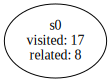

In [32]:
reload()
TOTAL = [x for _, x in load_work_map_all_years() if x.category == "snowball"]
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

state = strategy.initial
strategy.initial.visited

#strategy.initial.name
state


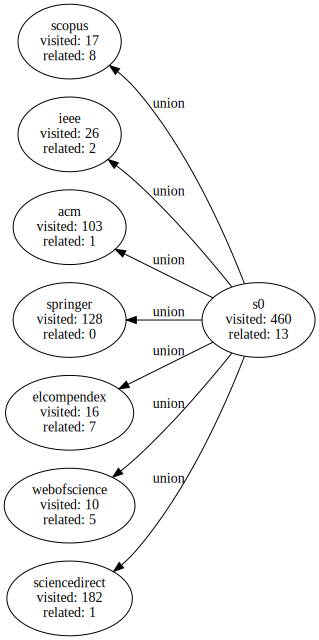

In [33]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["scopus", "ieee", "acm", "springer", "elcompendex", "webofscience", "sciencedirect"], filter_function)
#strategy.initial.find("acm")
strategy.initial

In [69]:
array = []

print ("--- Estratégia 1 (E1) ---")

name = "E1"
EP = len (state.related) / len (state.visited)
print ("Precision: " + "%.2f" %EP)

ER = len (state.related) / len (TOTAL)
print ("Recall: " + "%.2f" %ER)

FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.2f" %FS)

array.append((name, EP, ER, FS))

--- Estratégia 1 (E1) ---
Precision: 0.47
Recall: 0.36
F-Measure: 0.41


## Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

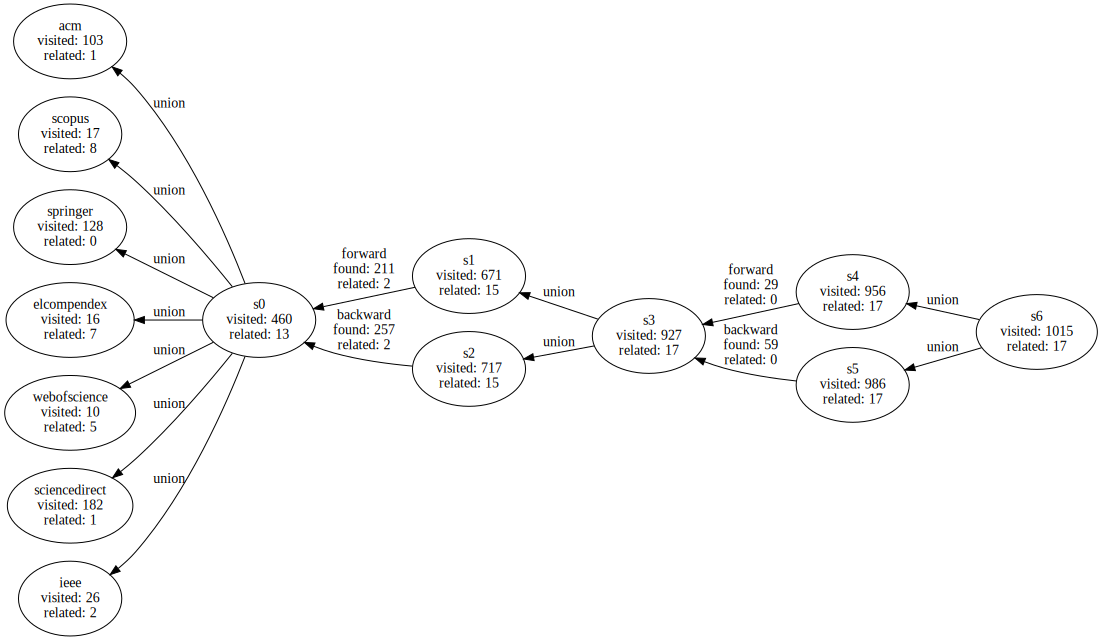

In [8]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm", "scopus", "springer", "elcompendex", "webofscience", "sciencedirect", "ieee"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

state

### Resumo 

#### Resumo da Busca em DL

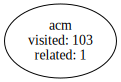

In [9]:
strategy.initial.find("acm")

In [10]:
# Visitados ACM
strategy.initial.find("acm").visited

{Human-automation Cooperation for Separation Assurance in Future NextGen Environments,
 Strategy Recommender Agents (ALEX) - the Methodology,
 Enterprise Architecture Coherence and the Model Driven Enterprise: Is Simulation the Answer or Are We Flying Kites?,
 Knowledge Management Framework for IT Project Portfolio Risk Management,
 Uncovering and Testing Archetypes of Effective Public Sector CIOs,
 Design Goal-oriented Level Design,
 Object Associations: A Simple and Practical Approach to Virtual 3D Manipulation,
 Towards Classification of DNS Erroneous Queries,
 Cheating and Plagiarism: Perceptions and Practices of First Year IT Students,
 Language, Culture and Boundary-spanning: Pushing the Frontiers of Research on Global Learning and Innovation,
 Conceptual Aspects of IT Governance in Enterprise Environment,
 Healthy Technology,
 Why Do Users Communicate via Such or Such Media?: Some Insights from Users' Daily Experiences,
 The Market of Internet Sponsored Links in the Context of C

In [11]:
# Relacionados ACM - encontrado no seed set
strategy.initial.find("webofscience").related

{Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 An approach to support the strategic alignment of software process improvement programs,
 ProPAMet: a Metric for process and project alignment,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals}

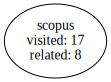

In [12]:
strategy.initial.find("scopus")

In [13]:
print("Visitados Scopus:")
strategy.initial.find("scopus").visited

Visitados Scopus:


{Using strategic planning for selection of SPI processes: An experience report,
 Alignment between the business strategy and the software processes improvement: A roadmap for the implementation [Alinhamento entre estrategia de negocios e melhoria de processos de software: Um roteiro de implementacao],
 Software process improvement for the airline industry,
 Empirical evaluation of selected best practices in implementation of software process improvement,
 A case study applying process and project alignment methodology,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 An approach to support the strategic alignment of so

In [14]:
print("Relacionados Scopus - encontrado no seed set:")
strategy.initial.find("scopus").related

Relacionados Scopus - encontrado no seed set:


{Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 An approach to support the strategic alignment of software process improvement programs,
 A Low-overhead method for software process appraisal,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals}

In [15]:
print("Artigo comum a ACM e Scopus:")
strategy.initial.find("acm").visited & strategy.initial.find("scopus").visited

Artigo comum a ACM e Scopus:


set()

#### Resumo do Snowballing

In [16]:
#Total de visitados = visitados no final - visitados no início
print ("Total visitados:")
len(state.visited - state.find("s0").visited)

Total visitados:


555

In [17]:
# Descrição dos Relacionados = relacionados no final - relacionados no início
print ("Total Relacionados: Lista dos que foram encontrados via Snowballing")
state.related - state.find("s0").related

Total Relacionados: Lista dos que foram encontrados via Snowballing


{Entropy based software processes improvement,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 Strategic alignment of software process improvement programs using QFD,
 Utilizing GQM+ Strategies for an organization-wide earned value analysis}

In [18]:
print ("Encontrados via somente Snowballing:")
diff_related = state.related - state.find("s2").related
diff_related @ metakey_title

Encontrados via somente Snowballing:


['petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)',
 'mandić2010a - Utilizing GQM+ Strategies for an organization-wide earned value analysis']

### Detalhamento por Estado / Aresta

#### Estado S0

#### Visitados

In [19]:
#S0 - Visitados
print("Visitados no Estado 0:")
state.find("s0").visited

Visitados no Estado 0:


{Enterprise integration using the agent paradigm: foundations of multi-agent-based integrative business information systems,
 Processes versus people: How should agile software development maturity be defined?,
 Strategy Recommender Agents (ALEX) - the Methodology,
 Introduction to Software Quality,
 An expert system in the domain of software technology transfer,
 Object Associations: A Simple and Practical Approach to Virtual 3D Manipulation,
 A sociotechnical approach towards alignment,
 The pursuit of cognition in manufacturing organizations,
 Test process assessments and improvement,
 What do software practitioners really think about project success: A cross-cultural comparison,
 OSS Integration Issues and Community Support: An Integrator Perspective,
 Effective Software Project Management Education through Simulation Models: An Externally Replicated Experiment,
 Summaries of PIE Reports,
 Language, Culture and Boundary-spanning: Pushing the Frontiers of Research on Global Learning

#### Relacionados - Seed Set

In [20]:
#S0 - Relacionados - Encontrados via busca e que existem na lista dos Incluídos da SLR existente - são os seed set!
print("Relacionados no Estado 0: Seed Set")
state.find("s0").related @ metakey_title

Relacionados no Estado 0: Seed Set


['mandić2010b - Utilizing GQM+ Strategies for business value analysis: An approach for evaluating business goals',
 'guzmán2010a - Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations',
 "reiblein1997a - SPI:\x91I can't get no satisfaction\x92-directing process improvement to meet business needs",
 'becker2008a - An approach to support the strategic alignment of software process improvement programs',
 'basili2010a - Linking software development and business strategy through measurement',
 'wilkie2007a - A Low-overhead method for software process appraisal',
 'barreto2010a - Defining and monitoring strategically aligned software improvement goals',
 'sommerville1999a - Managing process inconsistency using viewpoints',
 'kaneko2011a - Application of GQM+ Strategies{\textregistered} in the Japanese space industry',
 'martins2008a - ProPAMet: a Metric for process and project alignment',

#### Aresta s0 -> s2 (Backward - Iteração 1)

In [21]:
# S2 - Backward (Found) - Visitados na iteração 1
print("Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_visited

Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:


{Purchasing management and business competitiveness in the coming decade,
 Early empirical assessment of the practical value of GQM +strategies,
 Standard CMMI Appraisal Method for Process Improvement (SCAMPI) A, Version 1.2: Method Definition Document,
 An economic approach for improving requirements negotiation models with inspection,
 Goal question metric paradigm,
 Managing a designer/2000 project,
 Software Process Improvement: Practical Guidelines for Business Success,
 Value-based software engineering: Overview and agenda,
 Blue Ocean Strategy,
 Software Cost Estimation with COCOMO II,
 Factors of Software Process Improvement Success in Small and Large Organizations: An Empirical Study in the Scandinavian Context,
 Software measurement: Establishextractevaluateexecute,
 Deriving enterprise-based measures using the balanced scorecard and goal-driven measurement techniques,
 Elicit: A Method for Eliciting Process Models, Proc,
 Practical software measurement,
 Value-based softw

In [22]:
# S2 - Backward (Related) - Encontrados na iteração 1, via snowballing, que não foi encontrado via busca para o seed set.
print("Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_related @ metakey_title

Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:


['trienekens2009a - Entropy based software processes improvement',
 'becker2008b - Strategic alignment of software process improvement programs using QFD']

#### Aresta s0 -> s1 (Forward - Iteração 1)

In [23]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


['petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)',
 'mandić2010a - Utilizing GQM+ Strategies for an organization-wide earned value analysis']

#### Relacionados - Encontrados Via Backward e Forward

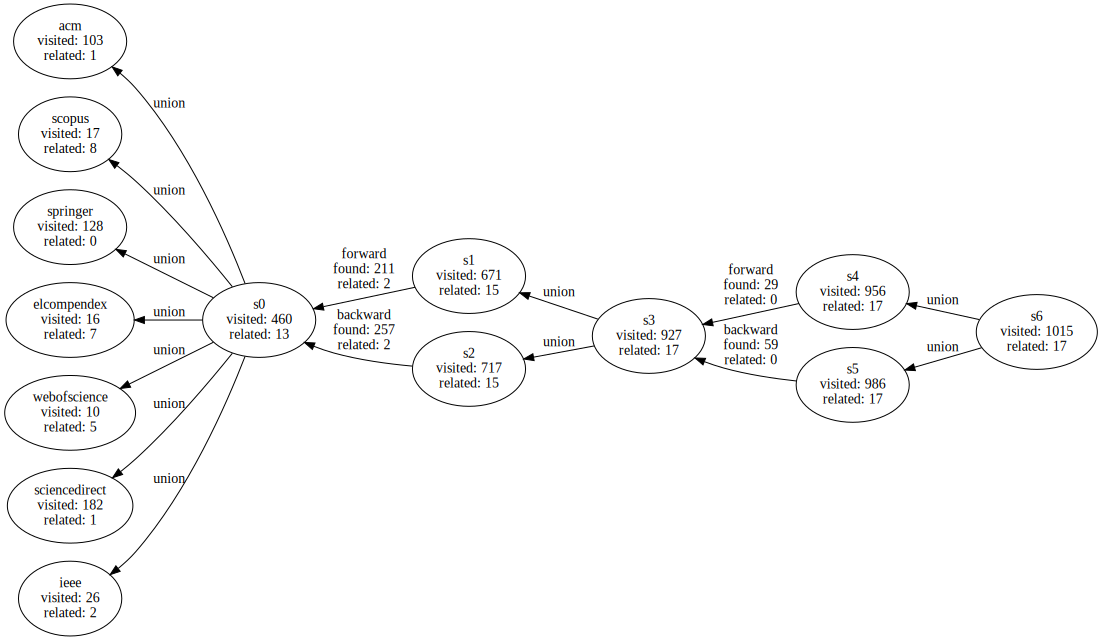

In [24]:
state

In [25]:
# Quantidade de artigo que existe em mais de uma biblioteca, após a união, no Estado S0, Ex, existe 1 artigo em acm e scopus.
state.find("s0").previous[0][1]

(len(strategy.initial.find("acm").visited) + len(strategy.initial.find("scopus").visited) + len(strategy.initial.find("elcompendex").visited) + len(strategy.initial.find("springer").visited) + len(strategy.initial.find("webofscience").visited) + len(strategy.initial.find("sciencedirect").visited)) - len(state.find("s0").visited)

-4

In [26]:
# Artigos encontrados via Backward e Forward - Foi incluído kitchenham 2007a como Snowball para o teste.
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[['trienekens2009a - Entropy based software processes improvement',
  'becker2008b - Strategic alignment of software process improvement programs using QFD'],
 ['petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)',
  'mandić2010a - Utilizing GQM+ Strategies for an organization-wide earned value analysis']]

In [27]:
def duplicados(strategy, state):
    encontrados = set()
    result = set()
    soma = 0
    related = state.related - state.find("s0").related
    for work in state.related:
        inter = encontrados & (set(strategy.ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "backward", inter @ metakey)
        inter = encontrados & (set(strategy.rev_ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "forward", inter @ metakey)
    return soma

In [28]:
strategy.forward??

In [29]:
duplicados(strategy, state)

0

<IPython.core.display.Javascript object>


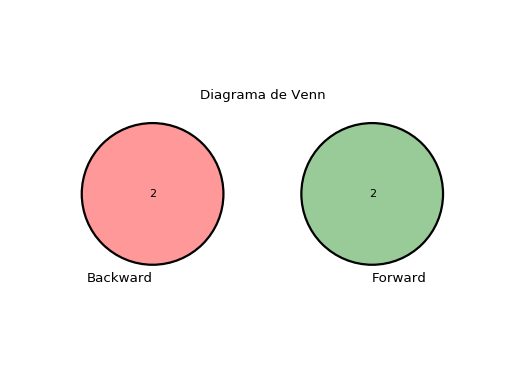

In [30]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [31]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['trienekens2009a', 'becker2008b']
Forward ['petersen2015a', 'mandić2010a']


In [32]:
state.find("s0").related @ metakey

['mandić2010b',
 'guzmán2010a',
 'reiblein1997a',
 'becker2008a',
 'basili2010a',
 'wilkie2007a',
 'barreto2010a',
 'sommerville1999a',
 'kaneko2011a',
 'martins2008a',
 'albuquerque2009a',
 'trienekens2005a',
 'plösch2011a']

In [33]:
#x = v.get_patch_by_id('100')

In [34]:
#x.set_linestyle = "black"

In [35]:
#[x.metakey for x in state.find("s0").related]

#### Execução de Backward (Aresta S0 -> S2) em cada artigo relacionado do S0

In [36]:
print("Descreve o S0 -> S2:\n Execução de Backward em cada artigo do related \n")
descreve_delta(strategy, state, "s2")

Descreve o S0 -> S2:
 Execução de Backward em cada artigo do related 

backward mandić2010b
- sharma2008a 
- thomas2001a 
- mandić2010c 
- boehm2005a 
- basili1994a 
- basili2007b 
- halling2003a 
- tierstein1997a 
- boehm2003a 
- basili2007a 
- biffl2006a 
- grünbacher2006a 
- solingen2004a 
- emam2005a 
- boehm2006a 
- brynjolfsson2000a 
- berry2006a 
- solingen1999a 
- ieee1981a 
- boehm2003b 
- basili2010b 
- harrison2006a 
- basili1993a 
- faulk2010a 
- reifer2002a 
- rodger1999a 
- erdogmus2004a 
- basili1984a 
- böckle2004a 
- thorp2003a 
- basili2010c 
- little2004a 
backward guzmán2010a
- mehra2004a 
- issac2006a 
- oliveira2009a 
- el2001a 
- sei2006b 
- isoiec2004a 
- kaplan2005a 
- kahraman2007a 
- trienekens2009a related
- mcgarry2002a 
- ebert2007a 
- goethert2003a 
- goethert2004a 
- kaplan1997a 
- card2003a 
- isoiec2007a 
- mishra2008a 
- tuan2006a 
- dyba2005a 
- kuppusamy2008a 
- gopal2005a 
- chastek2009a 
- porter1979a 
- fahey2007a 
- long2008a 
- watson2007a 
- k

#### Execução de Forward em cada artigo relacionado do S1

In [37]:
print("Descreve o S0 -> S1:\n Execução de Forward em cada artigo do related \n")
descreve_delta(strategy, state, "s1")

Descreve o S0 -> S1:
 Execução de Forward em cada artigo do related 

backward mandić2010b
- mandić2010c 
forward mandić2010b
- kobori2014b 
- basili2014b 
- dymek2015a 
- kobori2014a 
- papa2015a 
- roditi2014a 
- ellis2012a 
- fernández2011a 
- basili2014c 
- münch2013c 
- mandić2010a related
- ellis2013a 
- cocozza2014a 
- mandić2010g 
- astromskis2014a 
- hyvönen2015a 
- petersen2015a related
- asghari2012a 
- trendowicz2014a 
- tyrväinen2015a 
forward guzmán2010a
- mitre2014a 
- cyrus2011a 
- valenciennes2013a 
- barreto2011a 
- salgado2015a 
- dadhich2012a 
- pryor2011a 
- becker2012a 
- ramos2015a 
- hamouda2013a 
- lópez2012a 
- haghighatfar2013a 
- aguirre2014a 
forward reiblein1997a
- bowers2001a 
- stelzer1998b 
- makipaa2004a 
- schalken2007a 
- halloran1999a 
- brouwer2007a 
- murakami2007a 
- donkin2002a 
- baddoo2001a 
- alshawi2007a 
forward basili2010a
- mandić2010c 
- hernández2010a 
- unterkalmsteiner2014a 
- trendowicz2013a 
- kläs2013a 
- mandić2012ab 
- machado201

#### Resumo do Precision e Recall

In [38]:
E2P = len (strategy.initial.related) / len (strategy.initial.visited)
#print (len (strategy.initial.related))
#print (len (strategy.initial.visited))
#print (E2P)
print ("Precision na Busca E2: %.2f%%" % E2P)

#print ("Precision no Snowballing - E2:")
#print(len(state.related - state.find("s0").related))
#print(len(state.visited - state.find("s0").visited))

E2PS = len(state.related - state.find("s0").related) / len(state.visited - state.find("s0").visited)

print ("\n""Precision no Snowballing E2: %.2f%%" % E2PS)

print("Precision no Snowballing E2 - Forward - 1 iteração: %.2f%%" % (len (state.find("s1").delta_related) / len (state.find("s1").delta_visited)))

print("Precision no Snowballing E2 - Backward - 1 iteração: %.2f%%" % (len (state.find("s2").delta_related) / len (state.find("s2").delta_visited)))

print("\n""Precision E2 (Busca + Snowballing): %.2f%%" % (len(state.related) / len(state.visited)))

#len (state.find("s1").related)

#len (state.find("s1").delta_related)
#len (state.find("s1").delta_visited)


name = "E2"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision na Busca E2: 0.03%

Precision no Snowballing E2: 0.01%
Precision no Snowballing E2 - Forward - 1 iteração: 0.01%
Precision no Snowballing E2 - Backward - 1 iteração: 0.01%

Precision E2 (Busca + Snowballing): 0.02%
Precision E2
0.016748768472906402
Recall E2
0.7727272727272727


In [39]:
from collections import deque
def precision_recall(state, total, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", "precision", "recall", "operation", 
        "related", "visited", "delta_related", "delta_visited",
        "accumulated_precision", "accumulated_recall",
    ]]
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = 0.0
            
        array.append([
            current.name,
            precision,
            len(current.delta_related) / len(total),
            current.previous[1] if current.previous else "-",
            len(current.related),
            len(current.visited),
            len(current.delta_related),
            len(current.delta_visited),
            accumulated_precision,
            len(current.related) / len(total),
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

In [40]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
df

14,state,precision,recall,operation,related,visited,delta_related,delta_visited,accumulated_precision,accumulated_recall
0,ieee,0.0769231,0.0909091,-,2,26,2,26,0.0769231,0.0909091
1,sciencedirect,0.00549451,0.0454545,-,1,182,1,182,0.00549451,0.0454545
2,webofscience,0.5,0.227273,-,5,10,5,10,0.5,0.227273
3,elcompendex,0.4375,0.318182,-,7,16,7,16,0.4375,0.318182
4,springer,0,0,-,0,128,0,128,0,0
5,scopus,0.470588,0.363636,-,8,17,8,17,0.470588,0.363636
6,acm,0.00970874,0.0454545,-,1,103,1,103,0.00970874,0.0454545
7,s0,0,0,union,13,460,0,0,0.0282609,0.590909
8,s2,0.0077821,0.0909091,backward,15,717,2,257,0.0209205,0.681818
9,s1,0.00947867,0.0909091,forward,15,671,2,211,0.0223547,0.681818


<IPython.core.display.Javascript object>


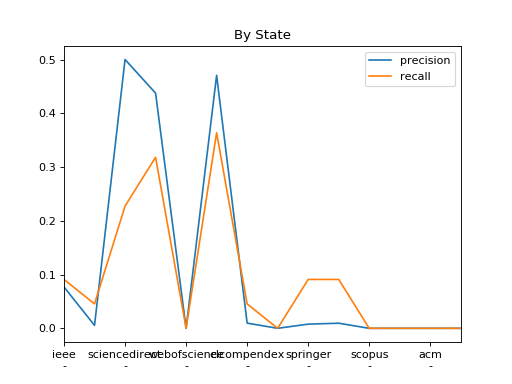

In [41]:
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");

<IPython.core.display.Javascript object>


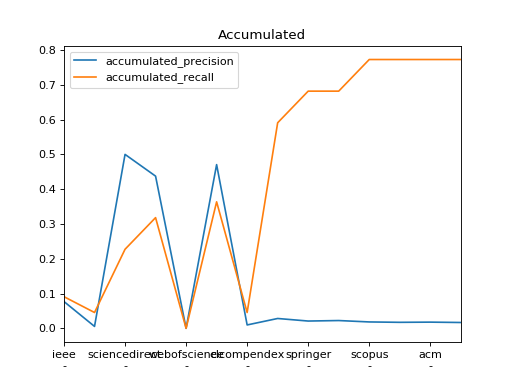

In [42]:
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("Accumulated");

## Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

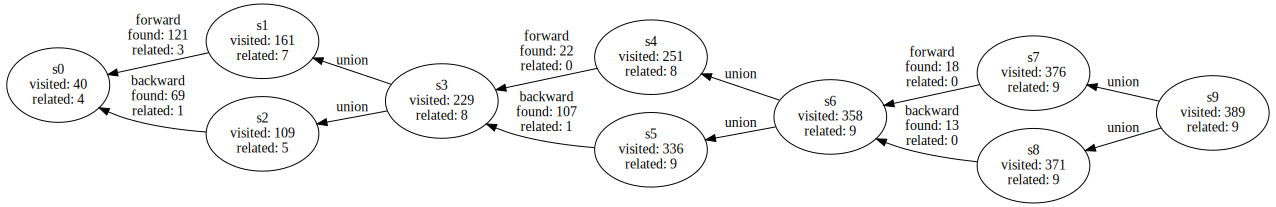

In [43]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
state

In [44]:
name = "E3"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E3
0.02313624678663239
Recall E3
0.4090909090909091



## Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

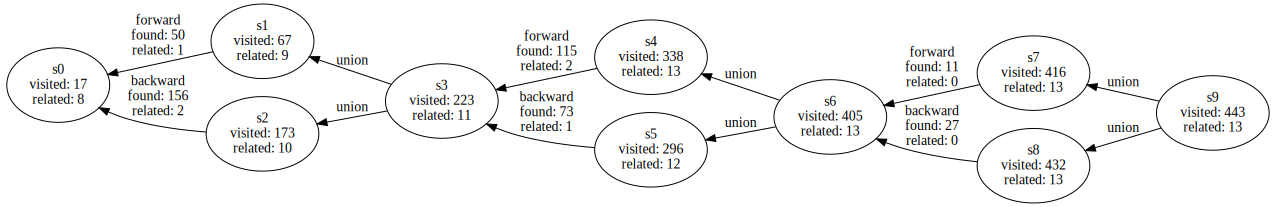

In [45]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

#from copy import copy
#strategy.initial.visited = copy(strategy.initial.related)
state = strategy.sfbu()
state

In [46]:
descreve_delta(strategy, state, "s2")


backward guzmán2010a
- mehra2004a 
- issac2006a 
- oliveira2009a 
- el2001a 
- sei2006b 
- isoiec2004a 
- kaplan2005a 
- kahraman2007a 
- trienekens2009a related
- mcgarry2002a 
- basili2010a related
- goethert2003a 
- ebert2007a 
- goethert2004a 
- kaplan1997a 
- card2003a 
- isoiec2007a 
- mishra2008a 
- tuan2006a 
- dyba2005a 
- kuppusamy2008a 
- gopal2005a 
- chastek2009a 
- porter1979a 
- fahey2007a 
- long2008a 
- watson2007a 
- kamel2009a 
- kojima2008a 
- kaplan2008a 
- el2007a 
- mcloone2007a 
- kanji2007a 
- peng2007a 
- lamb1984a 
- capell2004a 
- harjumaa2008a 
- shull2006a 
- qi2007a 
- neergaard2007a 
- kaplan2006a 
- asgarkhani2006a 
- basili2009b 
- isoiec2008a 
backward reiblein1997a
- vlasveld1995a 
- cmm1993a 
- itil1989a 
- iso1994b 
- hinley1997a 
- trade1992a 
- iso1994a 
- miller1995a 
- kaplan1996b 
- deming1986a 
- kaplan1993a 
- humphrey1989a 
- group1997a 
- isoies1997a 
backward becker2008a
- debou1999a 
- zahran1998a 
- pitterman2000a 
- biró1999a 
- dyba20

In [47]:
texto = """backward becker2008a
- weber2005a 
- hierholzer1998a 
- debou1999a 
- liu2005a 
- yamamura1999a 
- cox1992a 
- grady1997a 
- biró1999a 
- mccoy1998a 
- dyba2005a 
- humphrey1989b 
- paulk1993a 
- chrissis2003a 
- zaijun2005a 
- peterson1995a 
- brodman1995a 
- akao1990a 
- pitterman2000a 
- pulford1996a 
- montoni2007a 
- yin2003a 
- isoiec2003a 
- zahran1998a 
- niazi2003a 
backward martins2008a
- arthur1993a 
- isoiec1998a 
- salo2005a 
- krasner1997a 
- kuvaja1994a 
- cmm2002a 
- isoiec1998c 
- isoiec1998b 
- emam1999a 
- pfleeger1994a 
- solingen1999a 
- paulk1993a 
- vertage1994a 
- martins2007b 
backward reiblein1997a
- kaplan1993a 
- miller1995a 
- trade1992a 
- hinley1997a 
- vlasveld1995a 
- deming1986a 
- group1997a 
- iso1994b 
- itil1989a 
- iso1994a 
- cmm1993a 
- humphrey1989a 
- isoies1997a 
- kaplan1996b 
backward albuquerque2009a
- birk2002a 
- stalhane2004a 
- prahalad1999a 
- softex2009a 
- boehm2000b 
- cmusei2006a 
- nollen2008a 
- salo2005b 
- wright2000a 
- isoiec2004a 
- lawrence2001a 
- reed2000a 
- cater2004a 
- dybå2003b 
- birk1998a 
- bardin1977a 
- hefner2001a 
- thompson2000a 
- kim1995a 
- isoiec2004b 
- alloui2000a 
- caivano2005a 
- mcnair1990a 
- kaplan2000a 
- adams1993a 
- komi2004a 
- martins2007b 
backward kaneko2011a
- kathuria2007a 
- isaca2005a 
- kaplan1992a 
- basili2009a 
- basili2007b 
- becker1999a 
- isaca2008a 
- ogc2002a 
- basili1992a 
- jaxa2012a 
- kowalczyk2010a 
backward guzmán2010a
- ebert2007a 
- mcgarry2002a 
- goethert2004a 
- kaplan2008a 
- chastek2009a 
- tuan2006a 
- basili2009b 
- el2007a 
- sei2006b 
- kojima2008a 
- mishra2008a 
- long2008a 
- watson2007a 
- kanji2007a 
- oliveira2009a 
- porter1979a 
- lamb1984a 
- isoiec2007a 
- asgarkhani2006a 
- harjumaa2008a 
- mcloone2007a 
- mehra2004a 
- kamel2009a 
- card2003a 
- neergaard2007a 
- basili2010a related
- kaplan2005a 
- gopal2005a 
- peng2007a 
- kahraman2007a 
- isoiec2004a 
- fahey2007a 
- kaplan2006a 
- trienekens2009a related
- dyba2005a 
- shull2006a 
- el2001a 
- qi2007a 
- issac2006a 
- isoiec2008a 
- kaplan1997a 
- kuppusamy2008a 
- capell2004a 
- goethert2003a 
backward wilkie2007a
- iso2006a 
- anacleto2004b 
- wilkie2005a 
- mcfeeley1996a 
- anacleto2004a 
- makinen2000a 
- caffery2004a 
- sei2004a 
- wilkie2004a 
- cspt2003a 
- institute2005a 
- chrissis2003a 
- ISOIEC2006a 
- caffery2005a 
- mcfall2003a 
- sei2005a 
- paulk1995a 
- cignoni1999a 
- team2007a 
- rout2001a 
backward plösch2011a
- shewhart1931a 
- isoiec2003b 
- simon2002a 
- venzin2003a 
- cmmi2006a 
- mcfeeley1996a 
- isoiec1998d 
- dion1993a"""

In [48]:
conjuntos = [set(x.split("-")[1:]) for x in texto.split("backward")[1:]]

In [49]:
conjuntos[0] & conjuntos[1]

{' paulk1993a \n'}

In [50]:
name = "E4"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E4
0.029345372460496615
Recall E4
0.5909090909090909


In [51]:
state.find("s0").related

{Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 An approach to support the strategic alignment of software process improvement programs,
 A Low-overhead method for software process appraisal,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals}

In [52]:
state.find("s2").related

{Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 An approach to support the strategic alignment of software process improvement programs,
 Entropy based software processes improvement,
 Linking software development and business strategy through measurement,
 A Low-overhead method for software process appraisal,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals}

In [53]:
state.find("s0").visited

{Using strategic planning for selection of SPI processes: An experience report,
 Alignment between the business strategy and the software processes improvement: A roadmap for the implementation [Alinhamento entre estrategia de negocios e melhoria de processos de software: Um roteiro de implementacao],
 Software process improvement for the airline industry,
 Empirical evaluation of selected best practices in implementation of software process improvement,
 A case study applying process and project alignment methodology,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 An approach to support the strategic alignment of so

In [54]:
# Com backward de mendes2004a é possível encontrar 2 (resultado da celula)
state.related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

In [55]:
# Com backward de ... em S2, encontrou 1 (resultado da celula)
state.find("s2").delta_related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

In [56]:
# Com forward de ... em S1, encontrou 1 (resultado da celula)
state.find("s1").delta_related & set(strategy.rev_ref[work_by_varname("mendes2004a")])

set()

In [57]:
len(state.find("s1").delta_visited)

50

In [58]:
#len(state.find("s1").delta_visited & set(strategy.rev_ref[work_by_varname("mendes2004a")]))
# forward
len(set(strategy.rev_ref[work_by_varname("mendes2004a")]))

0

In [59]:
# backward
len(set(strategy.ref[work_by_varname("mendes2004a")]))

0

In [60]:
search_state = strategy.initial
search_state.related

{Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 An approach to support the strategic alignment of software process improvement programs,
 A Low-overhead method for software process appraisal,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals}

## Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

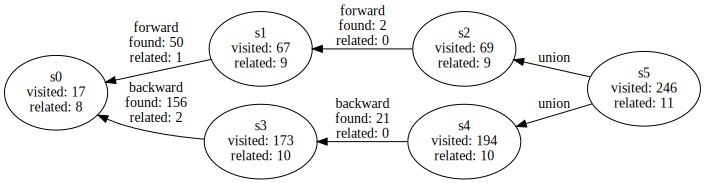

In [61]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.s2bbff2u()
state

In [62]:
name = "E5"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E5
0.044715447154471545
Recall E5
0.5


In [63]:
state.find("s0").related 

{Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 An approach to support the strategic alignment of software process improvement programs,
 A Low-overhead method for software process appraisal,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals}

In [64]:
state.find("s1").related 

{Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 An approach to support the strategic alignment of software process improvement programs,
 A Low-overhead method for software process appraisal,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals}

In [65]:
state.find("s3").related 

{Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 An approach to support the strategic alignment of software process improvement programs,
 Entropy based software processes improvement,
 Linking software development and business strategy through measurement,
 A Low-overhead method for software process appraisal,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals}

In [66]:
sx, sy = state.previous[0]

sx.related & sy.related


{Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 An approach to support the strategic alignment of software process improvement programs,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Software process improvement: Supporting the linking of the software and the business strategies,
 A Low-overhead method for software process appraisal}

In [67]:
sx.name

's2'

In [68]:
sy.name

's4'

In [69]:
# Artigos encontrados via Backward e Forward - Foi incluído kitchenham 2007a como Snowball para o teste.
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[['trienekens2009a - Entropy based software processes improvement',
  'basili2010a - Linking software development and business strategy through measurement'],
 ['petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)']]

In [70]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


['petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)']

## Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

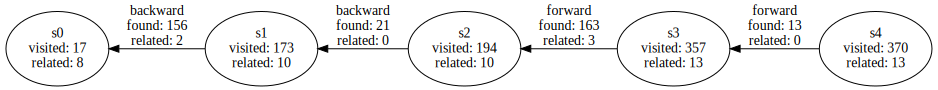

In [71]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.bbff()
state

In [72]:
strategy._repeat??

In [73]:
name = "E6"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E6
0.03513513513513514
Recall E6
0.5909090909090909


## Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

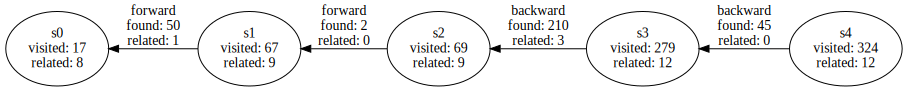

In [74]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.ffbb()
state

In [75]:
name = "E7"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E7
0.037037037037037035
Recall E7
0.5454545454545454


# Análise das Estratégias

In [76]:
%matplotlib notebook
import pandas as pd

In [77]:
df = pd.DataFrame (array,columns = ['Estratégia','Precision','Recall'])
df.index = df['Estratégia']
df

,Estratégia,Precision,Recall
Estratégia,,,
E1,E1,0.470588,0.363636
E2,E2,0.016749,0.772727
E3,E3,0.023136,0.409091
E4,E4,0.029345,0.590909
E5,E5,0.044715,0.500000
E6,E6,0.035135,0.590909
E7,E7,0.037037,0.545455


<IPython.core.display.Javascript object>


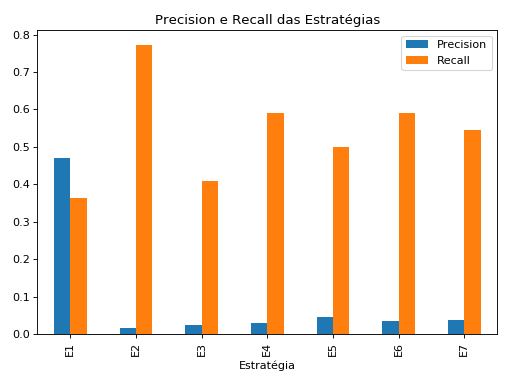

In [78]:
import matplotlib.pyplot as plt
ax = df.plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


In [79]:
df

,Estratégia,Precision,Recall
Estratégia,,,
E1,E1,0.470588,0.363636
E2,E2,0.016749,0.772727
E3,E3,0.023136,0.409091
E4,E4,0.029345,0.590909
E5,E5,0.044715,0.500000
E6,E6,0.035135,0.590909
E7,E7,0.037037,0.545455


In [80]:
#df.to_csv("estrategias.csv")
df.to_excel("estrategias.xlsx")

# Individual

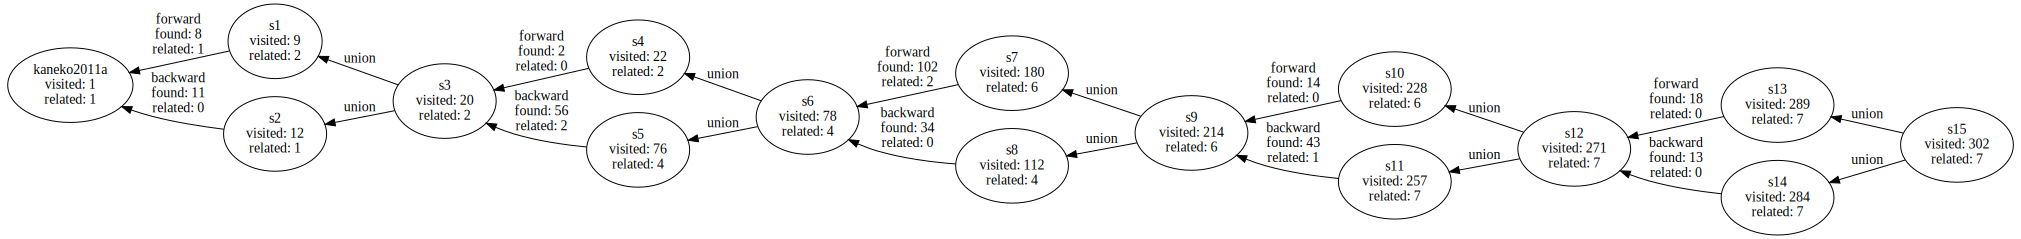

In [11]:
reload()
#NAME = "guzmán2010a"
NAME = "kaneko2011a"
filter_function = lambda x: x.category in ("snowball", "forward", "backward")
seedset = {work_by_varname(NAME)}
strategy = Strategy(seedset, filter_function)
strategy.initial.name = NAME
state = strategy.sfbu()
state

In [14]:
state.find("s1").delta_visited

{Tutorial: business IT alignment using the GQM+ Strategies{	extregistered} approach,
 Towards a Semantic Alignment of the ArchiMate Motivation Extension and the Goal-Question-Metric Approach,
 Identifying rationales of strategies by stakeholder relationship analysis to refine and maintain GQM+ Strategies models,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 SINIS: A Method to Select Indicators for IT Services,
 Como guiar a las Pymes en la mejora de procesos software,
 How to Lead the Software Process Improvement in SMEs,
 Evaluating GQM+ Strategies Framework for Planning Measurement System}

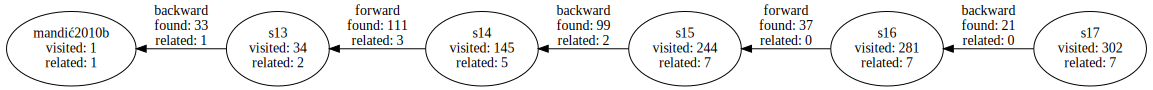

In [83]:
strategy.bfbf()